# Import libraries

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

# Test on one dataset

## Our Dataset

In [3]:
# Load waypoints
file_name = "DL_C_F_BRTL_4"
output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line/{file_name}"
# output_dir = f"/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop/{file_name}"

data_path = os.path.join(output_dir, "pose_waypoints_sampled_10hz_clean.csv") # A 10hz dataset
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv") # A 2.5hz dataset


# Set parameters
plot_2 = False # To plot the 2.5hz dataset on the same graph
speed_avg = False # To use the averaged linear velocity of last steps
pred_model = 'CTRV' # The prediction model to be used

In [4]:
# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])

# Read the CSV file with a header
with open(data_path_2, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
gt_array_2 = np.array(ground_truth_2)

print("Ground truth data loaded with the length: ", len(ground_truth))

Ground truth data loaded with the length:  24


## ETH Dataset

In [ ]:
# Load waypoints
file_name = "ETH_datasets"
output_dir = f"/home/sina/env_prediction_project/motion_predictor/{file_name}"

data_path = os.path.join(output_dir, "biwi_eth.csv") # A 10hz dataset
data_path_2 = os.path.join(output_dir, "pose_waypoints_sampled_2.5hz_clean.csv") # A 2.5hz dataset

# Set parameters
plot_2 = False # To plot the 2.5hz dataset on the same graph
speed_avg = False # To use the averaged linear velocity of last steps
pred_model = 'CTRV' # The prediction model to be used

In [ ]:
desired_ped_id = 201

# Parse ground truth data
ground_truth = []
ground_truth_2 = []

# Read the CSV file with a header
with open(data_path, "r") as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        ped_id = float(row["ped_id"])
        if ped_id == desired_ped_id:
            ground_truth.append([float(row["timestamp"]), ped_id, float(row["x"]), float(row["y"])])

# # Read the CSV file with a header
# with open(data_path_2, "r") as csvfile:
#     reader = csv.DictReader(csvfile)
#     for row in reader:
#         ground_truth_2.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
        
gt_array = np.array(ground_truth)
# gt_array_2 = np.array(ground_truth_2)

print("Ground truth data loaded with the length: ", len(ground_truth))

Ground truth data loaded with the length:  17


In [ ]:
# # DANGER!! INITIALIZED THE RESULTS_DF FROM THE BEGINNING

# # Make an empty dataframe to store the error values in next steps
# results_df = pd.DataFrame()

## Prediction Section

In [6]:
# Set prediction horizon
ph = 4

predictions = {}

# Group data by pedestrian ID (column 1)
pedestrian_ids = np.unique(gt_array[:, 1])

for ped_id in pedestrian_ids:
    # Filter data for the current pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    
    # Initialize predictions for this pedestrian
    ped_predictions = {}
    
    for i in range(0, len(ped_data) - 2 - ph): # We need 2 first steps to calculate omega, and the last ph steps cannot be a base for the prediction (no ground truth after that)

        # Extract current and next timestep data
        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
        t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]

        dt1 = t1 - t0
        dt2 = t2 - t1

        if dt1 == 0 or dt2 == 0:
            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
            continue  # Avoid divide-by-zero
        
        # Calculate velocity (vx, vy)
        vx1 = (x1 - x0) / dt1
        vy1 = (y1 - y0) / dt1

        vx2 = (x2 - x1) / dt2
        vy2 = (y2 - y1) / dt2

        # Compute headings
        theta1 = np.arctan2(y1 - y0, x1 - x0)
        theta2 = np.arctan2(y2 - y1, x2 - x1)

        # Compute yaw rate and velocity
        dtheta = theta2 - theta1
        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize to the range [-pi, pi]
        omega = dtheta / dt2

        # Compute average velocity if the flag is True
        if speed_avg:
            v = (np.sqrt(vx2**2 + vy2**2) + np.sqrt(vx1**2 + vy1**2))/2
        else:
            v = np.sqrt(vx2**2 + vy2**2)


        ### PREDICTION PART ###

        ## Step-by-step ph-step prediction   

        next_predicted_points = []

        x_base = x2
        y_base = y2
        theta_base = theta2

        for j in range(ph):

            if abs(omega) > 1e-5:  # Non-zero turn rate
                dt_s = dt2
                radius = v / omega

                theta_next = theta_base + omega * dt_s
                x_next = x_base + radius * (np.sin(theta_next) - np.sin(theta_base))
                y_next = y_base - radius * (np.cos(theta_next) - np.cos(theta_base))

                theta_base = theta_next
                x_base = x_next
                y_base = y_next

            else:  # Straight-line motion
                dt_s = dt2
                x_next = x2 + vx2 * (j + 1) * dt_s
                y_next = y2 + vy2 * (j + 1) * dt_s

            next_predicted_points.append([x_next, y_next])


        # # One-shot ph-step prediction
        # dt = ph * dt2
        
        # if abs(omega) > 1e-5:  # Non-zero turn rate
        #     radius = v / omega
        #     x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
        #     y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
        # else:  # Straight-line motion
        #     x_next = x2 + vx2 * dt
        #     y_next = y2 + vy2 * dt

        # Time of last predicted point (not used)
        t_next = t2 + ph * dt2  # Assuming uniform timestep

        ped_predictions[t2] = next_predicted_points

    for t2 in ped_predictions:
        if t2 not in predictions:
            predictions[t2] = {}
    
        # Store the prediction
        predictions[t2][ped_id] = ped_predictions[t2]

## Extract the predicted positions

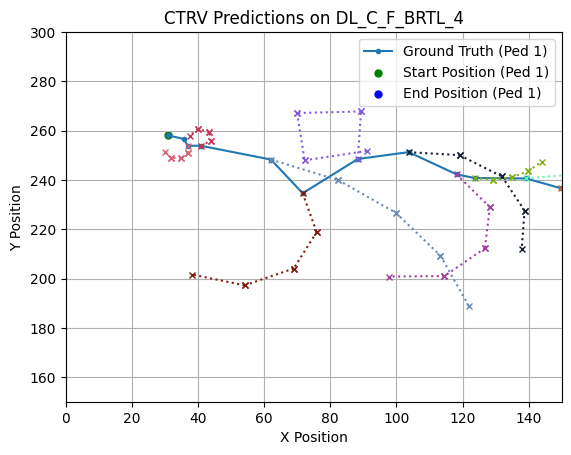

In [7]:
# # Assuming `data_array` and `predictions` are already computed as in the previous code

# # Extract x and y limits for the plot
# x_min, x_max = np.min(data_array[:, 2]), np.max(data_array[:, 2])
# y_min, y_max = np.min(data_array[:, 3]), np.max(data_array[:, 3])

# # Create the combined plot
# plt.figure(figsize=((x_max - x_min) * 0.5, (y_max - y_min) * 0.5), dpi=300)

# # Set the x and y axis limits
plt.xlim(0, 150)
plt.ylim(150, 300)

pedestrian_ids = np.unique(gt_array[:, 1])

# Plot ground truth trajectory (blue)
for ped_id in pedestrian_ids:
    # Filter ground truth data for the pedestrian
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    
    # Plot ground truth trajectory
    plt.plot(x_gt, y_gt, marker="o", linestyle="-", markersize=3,
             label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)
    
    if plot_2:
        # Filter ground truth data for the pedestrian (second dataset)
        ped_data_2 = gt_array_2[gt_array_2[:, 1] == ped_id]
        x_gt_2, y_gt_2 = ped_data_2[:, 2], ped_data_2[:, 3]

        # Plot ground truth trajectory (second dataset)
        plt.plot(x_gt_2, y_gt_2, marker="*", linestyle="-", markersize=3,
            label=f"Ground Truth (Ped {int(ped_id)})", linewidth=1.5)

    ## Plot predicted trajectory

    # Connect ground truth to prediction

    for t2, ped_pred in predictions.items():
        for ped_id, pred in ped_pred.items():
            ped_data = gt_array[gt_array[:, 1] == ped_id]
            gt_timestamps = ped_data[:, 0]

            if t2 in gt_timestamps:
                idx = np.where(gt_timestamps == t2)[0][0]
                x_start = ped_data[idx, 2]
                y_start = ped_data[idx, 3]

                color = np.random.rand(3,)

                for point in pred:
                    x_pred, y_pred = point
                    plt.plot([x_start, x_pred], [y_start, y_pred],
                         color=color, linestyle='dotted',
                         marker="x", markersize=4)
                    
                    x_start, y_start = x_pred, y_pred
                    # break


    ## THESE PLOTS ARE NOT WORKING ANYMORE
    # plt.plot(p_x, p_y, marker="x", linewidth=1, linestyle='--', label='Predicted Positions', color="red") # Connect all prediction to each other, only useful for one-step prediction
    # plt.scatter(p_x, p_y, marker="x", label='Predicted Positions', color="red") # Just show the predicted positions

# Mark start and end positions
for ped_id in np.unique(gt_array[:, 1]):
    ped_data = gt_array[gt_array[:, 1] == ped_id]
    x_gt, y_gt = ped_data[:, 2], ped_data[:, 3]
    plt.scatter(x_gt[0], y_gt[0], color="green", s=25, label=f"Start Position (Ped {int(ped_id)})")
    plt.scatter(x_gt[-1], y_gt[-1], color="blue", s=25, label=f"End Position (Ped {int(ped_id)})")
#     plt.scatter()
#     [40.77488327026367, 253.8969268798828],
#  [0.4355576923076923, 1.0, 62.06704711914063, 248.269775390625],
#  [0.51475, 1.0, 71.64285278320312, 234.6148834228516],
    
# plt.gca().invert_yaxis()  # Invert Y to match video coordinates
# plt.gca().invert_xaxis()  # Invert X to match video coordinates

# Titles and labels
plt.title(f"{pred_model} Predictions on {file_name}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
plt.close()

In [8]:
error_fde = []
error_fde_normal = []

error_ade = []
error_ade_normal = []

i = 0
for t2, ped_dict in predictions.items():
    for ped_id, pred_list in ped_dict.items():
        # Skip empty predictions
        if len(pred_list) < 1:
            continue


        # Get corresponding ground truth for ped_id
        ped_data = gt_array[gt_array[:, 1] == ped_id]
        gt_timestamps = ped_data[:, 0]


        if t2 not in gt_timestamps:
            print("Unexpected ERROR! The prediction base timestep is not present in ground truth")
            continue

        start_idx = np.where(gt_timestamps == t2)[0][0]
        target_idx = start_idx + ph


        if target_idx >= len(ped_data):
            print('Not enough GT data to evaluate')
            continue

        # --- FDE ---

        # Get the last predicted point (FDE)
        pred_fde = np.array(pred_list[-1])
        gt_fde = np.array([ped_data[target_idx, 2], ped_data[target_idx, 3]])
        dist_fde = np.linalg.norm(pred_fde - gt_fde)
        error_fde.append(dist_fde)

        # Normalized error over ground truth path (t2 to t_target)
        steps_size_fde = 0

        for j in range(1, ph + 1):
            if start_idx + j >= len(ped_data):
                break
            step_start = np.array([ped_data[start_idx + j - 1, 2], ped_data[start_idx + j - 1, 3]])
            step_end = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
            steps_size_fde += np.linalg.norm(step_end - step_start)

        if steps_size_fde > 0:
            error_fde_normal.append(dist_fde / steps_size_fde)

        # --- ADE ---

        total_dist = 0
        total_dist_normalized = 0
        valid_steps = 0

        for j in range(ph):
            if start_idx + j + 1 >= len(ped_data) or j >= len(pred_list):
                break

            pred_step = np.array(pred_list[j])
            gt_step = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
            dist_step = np.linalg.norm(pred_step - gt_step)
            total_dist += dist_step

            # Normalize by step size between GT positions
            step_start = np.array([ped_data[start_idx + j, 2], ped_data[start_idx + j, 3]])
            step_end = np.array([ped_data[start_idx + j + 1, 2], ped_data[start_idx + j + 1, 3]])
            step_size = np.linalg.norm(step_end - step_start)

            if step_size > 0:
                total_dist_normalized += dist_step / step_size

            valid_steps += 1

        if valid_steps > 0:
            error_ade.append(total_dist / valid_steps)
            error_ade_normal.append(total_dist_normalized / valid_steps)



        i += 1

# Compute and print averages
fde_avg = np.average(error_fde)
ade_avg = np.average(error_ade)
print('Final displacement error (FDE): {:.3f}'.format(fde_avg))
print('Average displacement error (ADE): {:.3f}'.format(ade_avg))

fde_avg_normal = np.average(error_fde_normal)
ade_avg_normal = np.average(error_ade_normal)
print('Normalized FDE: {:.3f}'.format(fde_avg_normal))
print('ADE Normalized: {:.3f}'.format(ade_avg_normal))


Final displacement error (FDE): 49.285
Average displacement error (ADE): 29.101
Normalized FDE: 0.824
ADE Normalized: 2.189


In [27]:
# # Define file names and data paths
# file_names = ["DL_C_F_BRTL_1", "DL_C_F_BRTL_2", "DL_C_F_BRTL_3", "DL_C_F_BRTL_4", "DL_C_F_BRTL_5", "DL_C_F_BRTL_6"]
# data_files = ["pose_waypoints_sampled_10hz_clean.csv", "pose_waypoints_sampled_2.5hz_clean.csv", "pose_waypoints_full_clean.csv"]

# Directory for datasets
base_dir = "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line"
# base_dir = '/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop'

# Placeholder for results
results = []

# Loop through file names and data files
for root, dirs, files in os.walk(base_dir):

    dataset_name = root.split("/")[-1]
    if dataset_name.startswith('x_'):
        continue

    for file in files:

        if file.endswith("_raw.csv") or not file.endswith("_2.5hz_clean.csv"):
            continue
        
        data_path = os.path.join(root, file)

        # Load data and calculate prediction error
        try:
            # Parse ground truth data
            ground_truth = []

            # Read the CSV file with a header
            with open(data_path, "r") as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                    
            gt_array = np.array(ground_truth)

            # Group data by pedestrian ID (column 1)
            pedestrian_ids = np.unique(gt_array[:, 1])
            predictions = {}

            ph = 1

            for ped_id in pedestrian_ids:
                # Filter data for the current pedestrian
                ped_data = gt_array[gt_array[:, 1] == ped_id]
                
                # Initialize predictions for this pedestrian
                ped_predictions = []
                
                for i in range(0, len(ped_data) - 1 - ph):
                    # Extract current and next timestep data
                    t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                    t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                    t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]
                    
                    dt1 = t1 - t0
                    dt2 = t2 - t1

                    if dt1 == 0 or dt2 == 0:
                        print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
                        continue  # Avoid divide-by-zero
                    
                    # Calculate velocity (vx, vy)
                    vx1 = (x1 - x0) / dt1
                    vy1 = (y1 - y0) / dt1

                    vx2 = (x2 - x1) / dt2
                    vy2 = (y2 - y1) / dt2

                    # Compute headings
                    theta1 = np.arctan2(y1 - y0, x1 - x0)
                    theta2 = np.arctan2(y2 - y1, x2 - x1)

                    # Compute yaw rate and velocity
                    dtheta = theta2 - theta1
                    dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize
                    omega = dtheta / dt2

                    v = np.sqrt(vx2**2 + vy2**2)

                    ### PREDICTION PART ###

                    dt = ph * dt2

                    if abs(omega) > 1e-5:  # Non-zero turn rate
                        radius = v / omega
                        x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
                        y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
                    else:  # Straight-line motion
                        x_next = x2 + vx2 * dt
                        y_next = y2 + vy2 * dt

                    # Predict next position assuming constant velocity
                    t_next = t2 + dt  # Assuming uniform timestep
        
                    # Store the prediction
                    ped_predictions.append([t_next, ped_id, x_next, y_next])
                    
                # Store predictions for this pedestrian
                predictions[ped_id] = ped_predictions

            p_x = []
            p_y = []
            # Print predictions for each pedestrian
            for ped_id, pred in predictions.items():
                # print(f"Predictions for pedestrian {ped_id}:")
                for p in pred:
                    # print(p)
                    p_x.append(p[2])
                    p_y.append(p[3])

            
            error_fde = []
            error_fde_normal = []

            # Calculate ADE
            i = 0
            for _, _, x, y in ground_truth[2 + ph:]:
                    pred = np.array((p_x[i], p_y[i]))
                    gt = np.array((x, y))

                    dist = np.linalg.norm(pred - gt, axis=-1)
                    
                    error_fde.append(dist)


                    # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
        
                    steps_size = 0
                    for j in range(1, ph + 1):
                        step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                        step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                        steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                    # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                    # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                    # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                    error_fde_normal.append(dist / steps_size)

                    i += 1

            
            ade_avg = np.average(error_fde)
            # print('Average prediction error: {:.2f}'.format(ade_avg))

            ade_avg_normal = np.average(error_fde_normal)
            # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

            
            # Append result
            results.append({
                "dataset_name": dataset_name,
                "path_type": dataset_name[:4],
                "acceleration_type": dataset_name.split("_")[2],
                "path_direction": dataset_name.split("_")[3],
                "path_number": dataset_name.split("_")[4],
                "sample_rate": file.split("_")[-2],
                "ph": ph,
                "prediction_model": pred_model,
                "average_error": ade_avg,
                "average_error_normal": ade_avg_normal
            })

            # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
        except Exception as e:
            print(f"Error processing {dataset_name} with {file}: {e}")

# Display results
for result in results:
    print(result)

{'dataset_name': 'VL_C_F_TD_3', 'path_type': 'VL_C', 'acceleration_type': 'F', 'path_direction': 'TD', 'path_number': '3', 'sample_rate': '2.5hz', 'ph': 1, 'prediction_model': 'CTRV', 'average_error': np.float64(28.60558921955926), 'average_error_normal': np.float64(0.6627677270779081)}
{'dataset_name': 'VL_C_F_BU_5', 'path_type': 'VL_C', 'acceleration_type': 'F', 'path_direction': 'BU', 'path_number': '5', 'sample_rate': '2.5hz', 'ph': 1, 'prediction_model': 'CTRV', 'average_error': np.float64(nan), 'average_error_normal': np.float64(nan)}
{'dataset_name': 'VL_C_F_BU_6', 'path_type': 'VL_C', 'acceleration_type': 'F', 'path_direction': 'BU', 'path_number': '6', 'sample_rate': '2.5hz', 'ph': 1, 'prediction_model': 'CTRV', 'average_error': np.float64(22.27138050717328), 'average_error_normal': np.float64(0.38904305752414897)}
{'dataset_name': 'VL_C_F_TD_5', 'path_type': 'VL_C', 'acceleration_type': 'F', 'path_direction': 'TD', 'path_number': '5', 'sample_rate': '2.5hz', 'ph': 1, 'predict

/home/sina/miniconda3/envs/yolotracker/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:562: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/sina/miniconda3/envs/yolotracker/lib/python3.13/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [12]:
speed_avg = False

# Directories for datasets
base_dirs = [
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Vertical Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Horizontal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Straight Line/Diagonal Line",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Infinity Loop",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Square Path",
    "/home/sina/env_prediction_project/trajectory_detection/Recorded Datasets/Circular Path"
]

results = []

for base_dir in base_dirs:
    for root, dirs, files in os.walk(base_dir):

        dataset_name = root.split("/")[-1]
        if dataset_name.startswith('x_'):
            continue

        for file in files:

            if file.endswith("_raw.csv") or file.endswith("_2.5hz_clean.csv"):
                continue
            
            data_path = os.path.join(root, file)

            # Load data and calculate prediction error
            try:
                # Parse ground truth data
                ground_truth = []

                # Read the CSV file with a header
                with open(data_path, "r") as csvfile:
                    reader = csv.DictReader(csvfile)
                    for row in reader:
                        ground_truth.append([float(row["timestamp"]), float(row["ped_id"]), float(row["x"]), float(row["y"])])
                        
                gt_array = np.array(ground_truth)

                # Group data by pedestrian ID (column 1)
                pedestrian_ids = np.unique(gt_array[:, 1])
                predictions = {}

                ph = 4

                for ped_id in pedestrian_ids:
                    # Filter data for the current pedestrian
                    ped_data = gt_array[gt_array[:, 1] == ped_id]
                    
                    # Initialize predictions for this pedestrian
                    ped_predictions = []
                    
                    for i in range(0, len(ped_data) - 1 - ph):
                        # Extract current and next timestep data
                        t0, x0, y0 = ped_data[i, 0], ped_data[i, 2], ped_data[i, 3]
                        t1, x1, y1 = ped_data[i + 1, 0], ped_data[i + 1, 2], ped_data[i + 1, 3]
                        t2, x2, y2 = ped_data[i + 2, 0], ped_data[i + 2, 2], ped_data[i + 2, 3]
                        
                        dt1 = t1 - t0
                        dt2 = t2 - t1

                        if dt1 == 0 or dt2 == 0:
                            print(f"Skipping due to zero time difference for pedestrian {ped_id} at index {i}")
                            continue  # Avoid divide-by-zero
                        
                        # Calculate velocity (vx, vy)
                        vx1 = (x1 - x0) / dt1
                        vy1 = (y1 - y0) / dt1

                        vx2 = (x2 - x1) / dt2
                        vy2 = (y2 - y1) / dt2

                        # Compute headings
                        theta1 = np.arctan2(y1 - y0, x1 - x0)
                        theta2 = np.arctan2(y2 - y1, x2 - x1)

                        # Compute yaw rate and velocity
                        dtheta = theta2 - theta1
                        dtheta = np.arctan2(np.sin(dtheta), np.cos(dtheta))  # Normalize
                        omega = dtheta / dt2

                        if speed_avg:
                            v = (np.sqrt(vx2**2 + vy2**2) + np.sqrt(vx1**2 + vy1**2))/2
                        else:
                            v = np.sqrt(vx2**2 + vy2**2)

                        ### PREDICTION PART ###

                        dt = ph * dt2

                        if abs(omega) > 1e-5:  # Non-zero turn rate
                            radius = v / omega
                            x_next = x2 + radius * (np.sin(theta2 + omega * dt) - np.sin(theta2))
                            y_next = y2 - radius * (np.cos(theta2 + omega * dt) - np.cos(theta2))
                        else:  # Straight-line motion
                            x_next = x2 + vx2 * dt
                            y_next = y2 + vy2 * dt

                        # Predict next position assuming constant velocity
                        t_next = t2 + dt  # Assuming uniform timestep
            
                        # Store the prediction
                        ped_predictions.append([t_next, ped_id, x_next, y_next])
                        
                    # Store predictions for this pedestrian
                    predictions[ped_id] = ped_predictions

                p_x = []
                p_y = []
                # Print predictions for each pedestrian
                for ped_id, pred in predictions.items():
                    # print(f"Predictions for pedestrian {ped_id}:")
                    for p in pred:
                        # print(p)
                        p_x.append(p[2])
                        p_y.append(p[3])

                
                error_fde = []
                error_fde_normal = []

                # Calculate ADE
                i = 0
                for _, _, x, y in ground_truth[2 + ph:]:
                        pred = np.array((p_x[i], p_y[i]))
                        gt = np.array((x, y))

                        dist = np.linalg.norm(pred - gt, axis=-1)
                        
                        error_fde.append(dist)


                        # In case of multe-step ahead prediction, all intermediate step sizes all considered. Another option is just to consider the direct distance to from origin gt to the prediction's corresponding gt, which is not considered here.
            
                        steps_size = 0
                        for j in range(1, ph + 1):
                            step_start = np.array((ground_truth[i + j][2], ground_truth[i + j][3]))
                            step_end = np.array((ground_truth[i + j + 1][2], ground_truth[i + j + 1][3]))

                            steps_size += np.linalg.norm(step_end - step_start, axis=-1)

                        # step_start = np.array((ground_truth[i + 1][2], ground_truth[i + 1][3]))
                        # step_end = np.array((ground_truth[i + 2][2], ground_truth[i + 2][3]))
                        # step_size = np.linalg.norm(step_end - step_start, axis=-1)

                        error_fde_normal.append(dist / steps_size)

                        i += 1

                
                ade_avg = np.average(error_fde)
                # print('Average prediction error: {:.2f}'.format(ade_avg))

                ade_avg_normal = np.average(error_fde_normal)
                # print('Average prediction error normalized: {:.2f}'.format(ade_avg_normal))

                
                # Append result
                results.append({
                    "dataset_name": dataset_name,
                    "path_type": dataset_name[:4],
                    "acceleration_type": dataset_name.split("_")[2],
                    "path_direction": dataset_name.split("_")[3],
                    "path_number": dataset_name.split("_")[4],
                    "sample_rate": file.split("_")[-2],
                    "ph": ph,
                    "prediction_model": pred_model,
                    "speed_avg": speed_avg,
                    "average_error": ade_avg,
                    "average_error_normal": ade_avg_normal
                })

                # print(f"Processed {file_name} with {data_file}: Average Error = {ade_avg}")
            except Exception as e:
                print(f"Error processing {dataset_name} with {file}: {e}")

In [17]:
# Remove duplicate rows based on all columns and keep the last occurrence
results_df = pd.concat([results_df, pd.DataFrame(results)]).drop_duplicates(keep='last').reset_index(drop=True)
# df_filtered = results_df[results_df['data_file'].str.endswith('2.5hz_clean.csv')]

# Display the DataFrame
results_df
# df_filtered


,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
0,VL_C_F_TD_3,VL_C,F,TD,3,full,1,CTRV,True,4.570776,2.416931
1,VL_C_F_TD_3,VL_C,F,TD,3,2.5hz,1,CTRV,True,29.713660,0.663119
2,VL_C_F_TD_3,VL_C,F,TD,3,10hz,1,CTRV,True,11.672355,1.956156
3,VL_C_F_BU_5,VL_C,F,BU,5,full,1,CTRV,True,4.585323,1.036047
4,VL_C_F_BU_5,VL_C,F,BU,5,2.5hz,1,CTRV,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1025,CP_C_F_CCW_2,CP_C,F,CCW,2,10hz,4,CTRV,False,46.183334,1.114731
1026,CP_C_F_CCW_3,CP_C,F,CCW,3,full,4,CTRV,False,19.817525,0.927410
1027,CP_C_F_CCW_3,CP_C,F,CCW,3,10hz,4,CTRV,False,51.263852,1.056049
1028,CP_C_A_CW_1,CP_C,A,CW,1,full,4,CTRV,False,22.778492,0.972178


In [18]:
results_df.to_csv("results_df.csv", index=False)

In [20]:
results_df_filtered = results_df[
    (results_df['sample_rate'].isin(['2.5hz'])) & 
    (results_df['ph'] == 1) & 
    (results_df['acceleration_type'] == 'F') &
    (results_df['path_type'] == 'CP_C')
    ]

results_df_filtered
# results_df.groupby([
#     'path_type',
#     # 'acceleration_type',
#     'sample_rate'
#                     ]).agg({'average_error': ['mean', 'std'],
#     'average_error_normal': ['mean', 'std']}).reset_index()

,dataset_name,path_type,acceleration_type,path_direction,path_number,sample_rate,ph,prediction_model,speed_avg,average_error,average_error_normal
268,CP_C_F_CW_1,CP_C,F,CW,1,2.5hz,1,CTRV,True,22.576600,0.682508
271,CP_C_F_CCW_1,CP_C,F,CCW,1,2.5hz,1,CTRV,True,23.839219,0.831636
274,CP_C_F_CCW_111,CP_C,F,CCW,111,2.5hz,1,CTRV,True,44.401035,0.593480
283,CP_C_F_CW_4,CP_C,F,CW,4,2.5hz,1,CTRV,True,24.190936,0.610605
286,CP_C_F_CW_3,CP_C,F,CW,3,2.5hz,1,CTRV,True,21.045529,0.600733
289,CP_C_F_CW_2,CP_C,F,CW,2,2.5hz,1,CTRV,True,20.106997,0.457284
301,CP_C_F_CCW_2,CP_C,F,CCW,2,2.5hz,1,CTRV,True,23.470837,0.873554
304,CP_C_F_CCW_3,CP_C,F,CCW,3,2.5hz,1,CTRV,True,32.952603,0.678678
577,CP_C_F_CW_1,CP_C,F,CW,1,2.5hz,1,CTRV,False,24.274842,0.724972
580,CP_C_F_CCW_1,CP_C,F,CCW,1,2.5hz,1,CTRV,False,27.712740,0.947511
